# Problem Statement

Sentiment analysis remains one of the key problems that has seen extensive application of natural language processing. This time around, given the tweets from customers about various tech firms who manufacture and sell mobiles, computers, laptops, etc, *the task is to identify if the tweets have a negative sentiment towards such companies or products.*
___

**Evaluation Metric**: The metric used for evaluating the performance of classification model would be weighted F1-Score.

**Data**

- **train.csv** - For training the models, we provide a labelled dataset of 7920 tweets. The dataset is provided in the form of a csv file with each line storing a tweet id, its label and the tweet.

- **test.csv** - The test data file contains only tweet ids and the tweet text with each tweet in a new line.

- **sample_submission.csv** - The exact format for a valid submission

Most profane and vulgar terms in the tweets have been replaced with “$&@*#”. However, please note that the dataset still might contain text that may be considered profane, vulgar, or offensive.
___

# Solution Approach

We will be using **fastai** in order to build a sentiment analysis model in order to predict the sentiment score of tweets.

**fastai** is a libray in python built on top of PyTorch for performing Deep Learning tasks developed by Rachel Thomas, Jeremy Howard and others which is easy to use, intuitive to understand and also gives decent results which are comparable with state-of-the-art models.

In [ ]:
import pandas as pd                                                             # To create a dataframe out of the given data and also to store predictions eventually in csv format
pd.set_option('display.max_colwidth', -1)                                       # To view the complete tweet, otherwise portions of tweets are hidden or not visible
import numpy as np                                                              # For matrix & linear algebra related applications
import os                                                                       # For navigating files and repos

import warnings                                                                 # To suppress unnecessary warnings
warnings.filterwarnings('ignore')

from sklearn import metrics                                                     # For analyzing the results and picking the right threshold for binary classification
import matplotlib.pyplot as plt                                                 # For plotting graphs
from matplotlib import rcParams                                                 # For plotting appropriate sized figures
%matplotlib inline

from google.colab import drive                                                  # This is where we get the data from (i.e. drive)
drive.mount('/content/drive', force_remount = True)

%reload_ext autoreload                                                          # To refresh a file immediately and always make the latest versions of loaded files available
%autoreload 2

# Setting up fastai

You can refer [this website](https://course.fast.ai/start_colab.html) to set fastai for any environment you may be working on. It's better to refer these over other personal tutorials and stuff because it is directly from the developers and they update it periodically with new releases and stuff. 

The left margin contains options to configure fastai for various instances. Check that out depending on which system you're working on.

In [147]:
!curl -s https://course.fast.ai/setup/colab | bash

Updating fastai...
Done.


In [0]:
from fastai import *
from fastai.text import *

In [149]:
!nvidia-smi                                                                     # To check what version of GPU is made available for this instance of Colab

Thu Feb 27 15:06:41 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.48.02    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    30W / 250W |   2791MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

# Data Preparation

In any deep learning application, building the model is relatively a trivial job compared to the task of preprocessing it and brining it into a form where you can feed it to the network/model.

fastai provides a lot of different options to facilitate easy loading of data. 

Our data here is given in a `csv` file. We can load it into a pandas dataframe with an *appropriate encoding scheme* and then build our dataset based on these dataframes. I would highly recommend to follow this notebook along with [this tutorial](https://www.youtube.com/watch?v=qqt3aMPB81c) as everything would make sense pretty easily after you've watched this video.

Let's read in the dataset and see how it's structured and also a few entries from these datasets.

In [0]:
base_dir = '/content/drive/My Drive'
os.chdir(base_dir)

In [0]:
train_data = pd.read_csv(base_dir + '/Analytics_Vidhya_Identify_The_Sentiment/train.csv', encoding='latin-1')
test = pd.read_csv(base_dir + '/Analytics_Vidhya_Identify_The_Sentiment/test.csv', encoding = 'latin-1')

In [0]:
from sklearn.model_selection import train_test_split
train, valid = train_test_split(train_data, test_size = .1,random_state = 128)

In [153]:
train.head()

,id,label,tweet
867,868,0,Hello you ! #samsung #galaxys8 #borderless #phone #new #nice â¦ https://www.instagram.com/p/BTG2rFRhclvCJX1PkLWNrA3YVQSlF-OR5x-N_I0/ â¦
1362,1363,0,Happy Birthday to my Awesome Mommy! :) She's the best!! #mom #birthday #iphone #collage #kittyâ¦ http://instagr.am/p/Vj2_juTXLD/
1420,1421,0,Gentle creative digital art CHILDREN OF THE UNIVERSE http://bit.ly/14KPcqh #green #colors #home #decor #design #iPhone #cases
66,67,0,Photo: Can I love you less? No. #pink #iPhone #random #instamood #photography loljk http://tmblr.co/Z3TxIw14VJQl0
2388,2389,0,I love the smell of a new computer. Let's hope this one also last 8 years. #Apple #Mac #i7 #32GB #iMac #GeekPornpic.twitter.com/55sZgVxhmC


# Language Model

A Language Mode simply stated is a network which learns to predict the next word in a sentence based on current word and this iteratively continues forever until you manually put a stopping condition.

**Why would a language model help here?** 

The words in the review, they are meant to convey the emotion of a person based on which the label is assigned. A sequence of words is the input in this case and the sentiment underlying that sequence is the output. In order to build a network that learns to determine the sentiment, we will have to build a model that can handle a sequence input and return only one output. 

RNN *i.e. Recurrent Neural Networks* like LSTM networks or GRU Networks are capable of handling such data. But in order to build these, it's essential to express words as vectors as the network doesn't understand anything except numbers.

>In the process of building a language model, we learn the best way to numerically represent words as one-dimensional tensors which encapsulate contextual worldly knowledge which subsequently helps in classification.

Well, it's always better to start with a good set of weights than arbitrarily anyhow. So, fastai provides a language model which is trained on the entire Wikipedia Corpus and one start with the weights/coefficients of this model and then let the language model learn on the user-specified corpus. This can fine-tune the word-vector weights for a more targeted application.
___

For building a loader to fit a language model learner, fastai provides a class called `TextLMDataBunch` which creates a databunch object for systematically loading data into model for learning. There are several methods which could be used to initialize this object
- *from_csv*: If your data is in a csv format, you can use this method.

- *from_df*: If you've got a pandas dataframe in which you have loaded data and you want to build your dataset using this dataframe, this is the option you select.

- *from folder*: If your data is neatly organized in train, test folders and within them there are sub-folders for every class, then this method is well-suited to load your data.
___

Once you've loaded the data, you need to build a language model learner object to which you'll have to pass the databunch you just defined above and an architecture. This architecture could be the WikiText103 model learner which you can specify saying `AWD_LSTM` while passing the arch parameter of the language_model_learner.
___
Subsequently you can find the learning rate and train the model first with the end layers unfreezed and subsequently with all the layers unfreezed and you should see the accuracy metric rise. 

**Remember that even an accuracy of 30% or more is great for this model because this isn't our generic classification model; It's a language model. What this means is that given a sentence and if asked to predict the next word then the model is gonna predict a sensible output once every three times which is commendable.**



In [154]:
# Define the path where the data is and where you want your models to be stored
pth = base_dir + '/Analytics_Vidhya_Identify_The_Sentiment'

# Create a Databunch for the language model
data = TextLMDataBunch.from_df(path = pth, train_df = train, valid_df = valid, test_df = test, text_cols = ['tweet'], label_cols = ['label'], bs = 32, min_freq = 2)

In [0]:
# Create a learner object
learn = language_model_learner(data, AWD_LSTM)

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


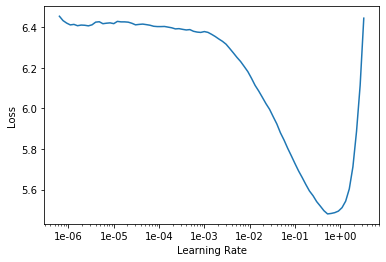

In [156]:
learn.lr_find()                                                                 # Find a suitable learning rate 
learn.recorder.plot()                                                           # Plot it to select one

In [0]:
learn.fit_one_cycle(5, 1e-3, moms = (.7,.6))                                    # Decide a nice learning rate from the curve above and train the model

epoch,train_loss,valid_loss,accuracy,time
0,5.849698,4.778185,0.302541,00:09


In [0]:
# Do the same thing as before but by unfreezing all the layers so that they all get trained this time
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(10, 1e-4, moms = (.8,.7))

In [0]:
# Save this model as it'll serve as the source for word's weight vectors when defining a text classification model
learn.save_encoder('fine_tuned.pkl')

# Text Classification Model

Now that you've created a learner model which has learned quite a bit in the world of tweets, you are ready to build a classifier.
___

To provide data to the classifier model for training, we can use the `TextClasDataBunch` class and use the `from_df` method to load the dataframes that we built earlier as train, test and validation dataloaders.

**Note: It's important here that you also define the vocabulary based on the language model learner's vocabulary. It must be the same!**
___

Learning process is very much similar to the language model learner. A slight difference here is that we first unfreeze only the last layer, train for a few epochs, then unfreeze last two layers and train for several epochs and eventually unfreeze all the layers and train for several epochs. This approach, Jeremy says works best in his empirical experience. So let's stick with it.
___
The `get_preds` method helps obtain a prediction for every sequence that it's passed. it returns a probability distribution which in this case is simply two values i.e. $P(Sentiment=-|Tweet) \  \& \ P(Sentiment = +|Tweet)$. We have to select an appropriate threshold to classify the sentiment positive or negative and take a decision.


Once we obtain the predictions on the validation dataset, we can plot an ROC-AUC Curve and find out the best threshold for the problem by determining the point where the $f_1$ score is the best out of all the thresholds. The $f_1$ gives weightage to both Recall and Precision and hence is a decent metric to look for when looking for a good threshold value.

In [0]:
data_classification = TextClasDataBunch.from_df(path = pth, train_df = train, valid_df = valid, test_df = test, text_cols=['tweet'], label_cols = ['label'], vocab = data.vocab, bs = 32)

In [0]:
classification_learner = text_classifier_learner(data_classification, arch = AWD_LSTM, drop_mult=0.4)
classification_learner.load_encoder('fine_tuned.pkl')
classification_learner.freeze()

In [0]:
classification_learner.lr_find()

In [0]:
classification_learner.recorder.plot()

In [0]:
classification_learner.fit_one_cycle(3, 1e-3, moms = (.8, .7))

In [0]:
classification_learner.lr_find()
classification_learner.recorder.plot()

In [0]:
classification_learner.freeze_to(-2)
classification_learner.fit_one_cycle(3, slice(1e-5/(2.6**4), 1e-5), moms = (.8, .7))

In [0]:
classification_learner.unfreeze()

In [0]:
classification_learner.lr_find()
classification_learner.recorder.plot()

In [0]:
classification_learner.fit_one_cycle(5, slice(5e-6/(2.6**4), 5e-6), moms = (.8, .7))

In [0]:
# Evaluating the model on validation dataset
probs, labels = classification_learner.get_preds(ds_type=DatasetType.Valid, ordered = True)

In [0]:
# Get the probabilities for positive class i.e. class 1 and all the labels to our cpu from GPU
labels = labels.numpy()
pos_class_probs = [i[1] for i in probs.numpy()]

In [0]:
# Compute the statistics False Positive Rate, True Positive Rate for different thresholds to 
# Draw an ROC Curve and determine the quality of classifier built.
fpr, tpr, thr = metrics.roc_curve(labels, pos_class_probs)
auc = metrics.auc(fpr, tpr)

rcParams['figure.figsize'] = 8, 5
plt.figure()
plt.plot(fpr, tpr, color = 'green', label = f"ROC Curve, AUC: {np.round(auc, 4)}")
plt.xlim([-.05,1.05])
plt.ylim([-.05,1.05])
plt.title("Receiver Operating Characteristics with +ve Class = 1")
plt.legend(loc = 'lower right')
plt.show()

In [0]:
# Come across the threshold with best f-1 score and select that threshold
f1_ = []
acc = []
for t in thr:
    preds = [1 if i > t else 0 for i in pos_class_probs]
    f1_.append(metrics.f1_score(labels, preds))
    acc.append(metrics.accuracy_score(labels, preds))

metrics_ = pd.DataFrame({'FPR':fpr, 'TPR': tpr, 'f1-score':f1_, 'accuracy':acc, 'Threshold':thr})

In [0]:
metrics_[metrics_['f1-score'] == metrics_['f1-score'].max()]

In [0]:
metrics_[metrics_['accuracy'] == metrics_['accuracy'].max()]

In [0]:
# Predict on test dataset and use the threshold obtained above for classifying the sentiments
# based on the obtained probability distribution
probs, labels = classification_learner.get_preds(ds_type=DatasetType.Test, ordered = True)

thresh = 0.5479
preds = []
for zero_prob, one_prob in probs:
    if thresh > zero_prob:
    preds.append(1)
    else:
    preds.append(0)

In [0]:
preds_ = pd.DataFrame({'id': list(test['id']), 'label': preds})
preds_.to_csv('Predictions-1.csv', index = False)